In [111]:
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install seaborn
# !pip install scikit-learn
# !pip install plotly

In [112]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, r_regression
from sklearn.preprocessing import StandardScaler, RobustScaler

import os

Link to project repository : https://github.com/EmoSense/data_explore

# Stage 1

## 1A : Brief Description of Data

### The World Happiness Report

* The World Happiness Report reviews the state of happiness across a multitude of countries based on a series of questions, with answers rated between 0 and 10. Six variables are then used to explain the overall 'happiness', comparing the outcome against a fictional country called Dystopia, which is a culmination of all the lowest ratings gathered that year.

https://worldhappiness.report/about/

* The data and inforation regrarding it was sourced from : https://worldhappiness.report/data/


In [113]:
happiness_report = pd.read_excel('data/DataForTable2.1WHR2023.xls')

### 1.1A Summary Statistics: Happiness Report

In [114]:
happiness_report.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2199.000000,2199.000000,2179.000000,2186.000000,2145.000000,2166.000000,2126.000000,2083.000000,2175.000000,2183.000000
mean,2014.161437,5.479226,9.389766,0.810679,63.294583,0.747858,0.000096,0.745195,0.652143,0.271501
std,4.718736,1.125529,1.153387,0.120952,6.901104,0.140150,0.161083,0.185837,0.105922,0.086875
min,2005.000000,1.281271,5.526723,0.228217,6.720000,0.257534,-0.337527,0.035198,0.178886,0.082737
25%,2010.000000,4.646750,8.499764,0.746609,59.119999,0.656528,-0.112116,0.688139,0.571684,0.207660
50%,2014.000000,5.432437,9.498955,0.835535,65.050003,0.769821,-0.022671,0.799654,0.663063,0.260671
75%,2018.000000,6.309460,10.373216,0.904792,68.500000,0.859382,0.092070,0.868827,0.737936,0.322894
max,2022.000000,8.018934,11.663788,0.987343,74.474998,0.985178,0.702708,0.983276,0.883586,0.704590


### 1.2A Column Headers: Happiness Report


In [115]:
list(happiness_report)

['Country name',
 'year',
 'Life Ladder',
 'Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Positive affect',
 'Negative affect']

### 1.3B Graphs : Happiness Report

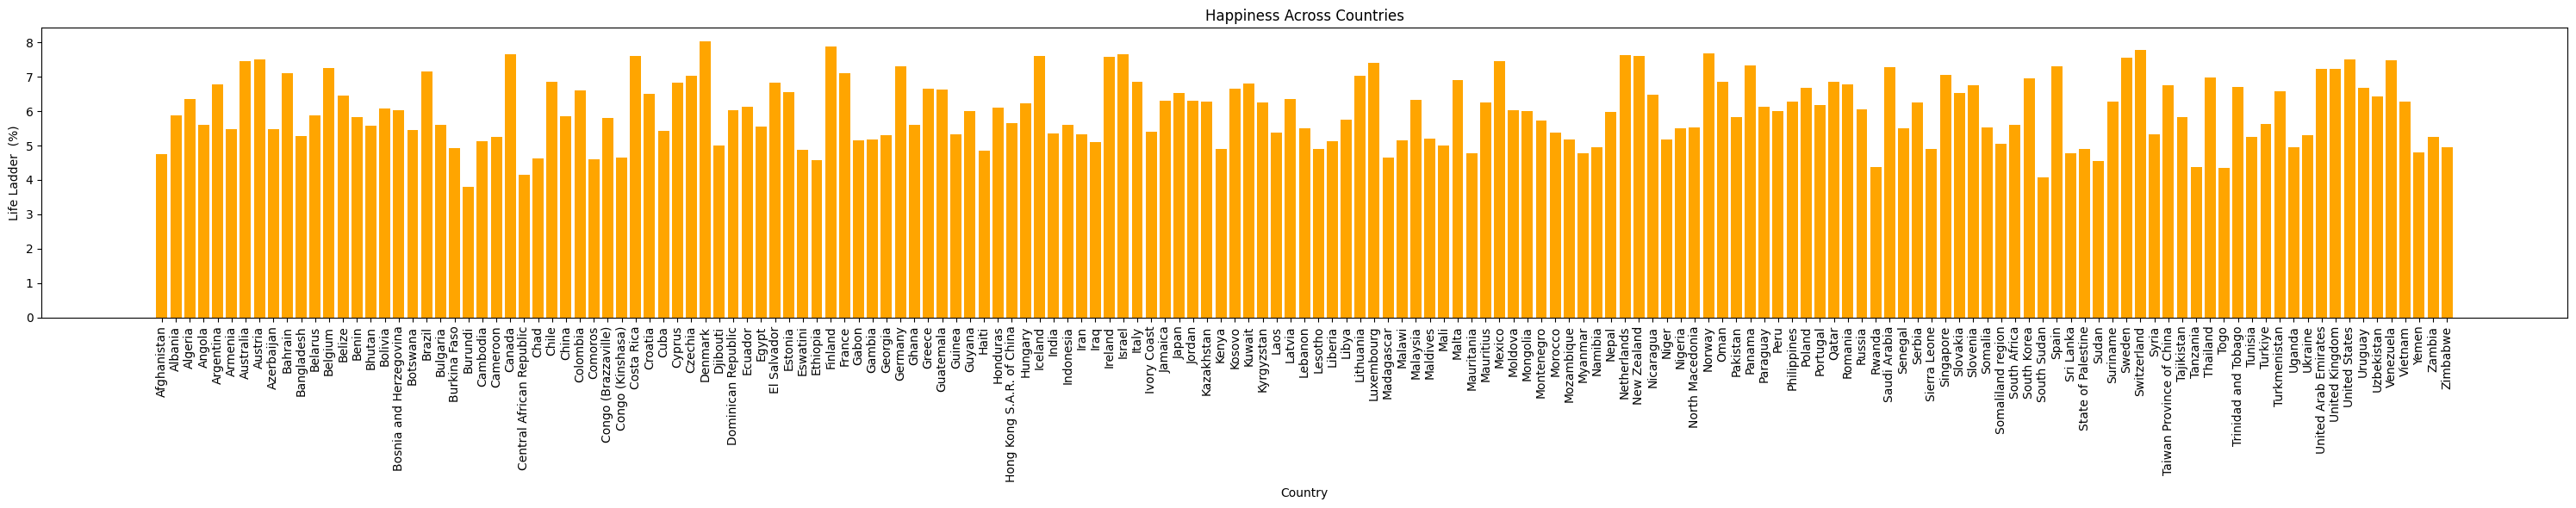

In [116]:
countries = happiness_report['Country name']
happiness = happiness_report['Life Ladder']

plt.figure(figsize=(30, 6))
plt.bar(countries, happiness, color='orange')
plt.xlabel('Country')
plt.ylabel('Life Ladder  (%)')
plt.title('Happiness Across Countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 1B : Brief Description of Data



### World Educational Data

* The World Educational Data contains information on various educational indicators from countries around the world. It includes a range of variables related to education, such as literacy rates, enrollment rates, birth rates, and unemployment rates.

* The data is taken from sources which were last updated in 2021.

* The data and inforation regarding it was sourced from : https://www.kaggle.com/datasets/nelgiriyewithana/world-educational-data


In [117]:
education_report = pd.read_excel('data/education_world.xls')

### 1.1B Summary Statistics: Education Report

In [118]:
education_report.describe()

,Latitude,Longitude,OOSR_Pre0Primary_Age_Male,OOSR_Pre0Primary_Age_Female,OOSR_Primary_Age_Male,OOSR_Primary_Age_Female,OOSR_Lower_Secondary_Age_Male,OOSR_Lower_Secondary_Age_Female,OOSR_Upper_Secondary_Age_Male,OOSR_Upper_Secondary_Age_Female,...,Primary_End_Proficiency_Reading,Primary_End_Proficiency_Math,Lower_Secondary_End_Proficiency_Reading,Lower_Secondary_End_Proficiency_Math,Youth_15_24_Literacy_Rate_Male,Youth_15_24_Literacy_Rate_Female,Birth_Rate,Gross_Primary_Education_Enrollment,Gross_Tertiary_Education_Enrollment,Unemployment_Rate
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,...,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,25.081422,55.166928,19.658416,19.282178,5.282178,5.569307,8.707921,8.831683,20.292079,19.975248,...,10.717822,10.376238,25.787129,24.450495,35.801980,35.084158,18.914010,94.942574,34.392574,6.000000
std,16.813639,45.976287,25.007604,25.171147,9.396442,10.383092,13.258203,14.724717,21.485592,23.140376,...,24.866101,22.484423,33.181384,31.965467,45.535186,45.249643,10.828184,29.769338,29.978206,5.273136
min,0.023559,0.824782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.685062,18.665678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.355000,97.200000,9.000000,2.302500
50%,21.207861,43.518091,9.000000,7.000000,1.000000,1.000000,2.000000,2.000000,15.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.550000,101.850000,24.850000,4.585000
75%,39.901792,77.684945,31.000000,30.000000,6.000000,6.750000,12.750000,10.750000,32.750000,30.000000,...,0.000000,0.000000,56.750000,50.750000,94.000000,96.750000,27.692500,107.300000,59.975000,8.655000
max,64.963051,178.065032,96.000000,96.000000,58.000000,67.000000,61.000000,70.000000,84.000000,89.000000,...,99.000000,89.000000,89.000000,94.000000,100.000000,100.000000,46.080000,142.500000,136.600000,28.180000


### 1.2B Column Headers : Education Report

In [119]:
list(education_report)

['Countries and areas',
 'Latitude ',
 'Longitude',
 'OOSR_Pre0Primary_Age_Male',
 'OOSR_Pre0Primary_Age_Female',
 'OOSR_Primary_Age_Male',
 'OOSR_Primary_Age_Female',
 'OOSR_Lower_Secondary_Age_Male',
 'OOSR_Lower_Secondary_Age_Female',
 'OOSR_Upper_Secondary_Age_Male',
 'OOSR_Upper_Secondary_Age_Female',
 'Completion_Rate_Primary_Male',
 'Completion_Rate_Primary_Female',
 'Completion_Rate_Lower_Secondary_Male',
 'Completion_Rate_Lower_Secondary_Female',
 'Completion_Rate_Upper_Secondary_Male',
 'Completion_Rate_Upper_Secondary_Female',
 'Grade_2_3_Proficiency_Reading',
 'Grade_2_3_Proficiency_Math',
 'Primary_End_Proficiency_Reading',
 'Primary_End_Proficiency_Math',
 'Lower_Secondary_End_Proficiency_Reading',
 'Lower_Secondary_End_Proficiency_Math',
 'Youth_15_24_Literacy_Rate_Male',
 'Youth_15_24_Literacy_Rate_Female',
 'Birth_Rate',
 'Gross_Primary_Education_Enrollment',
 'Gross_Tertiary_Education_Enrollment',
 'Unemployment_Rate']

### 1.3B Graphs : Education Report

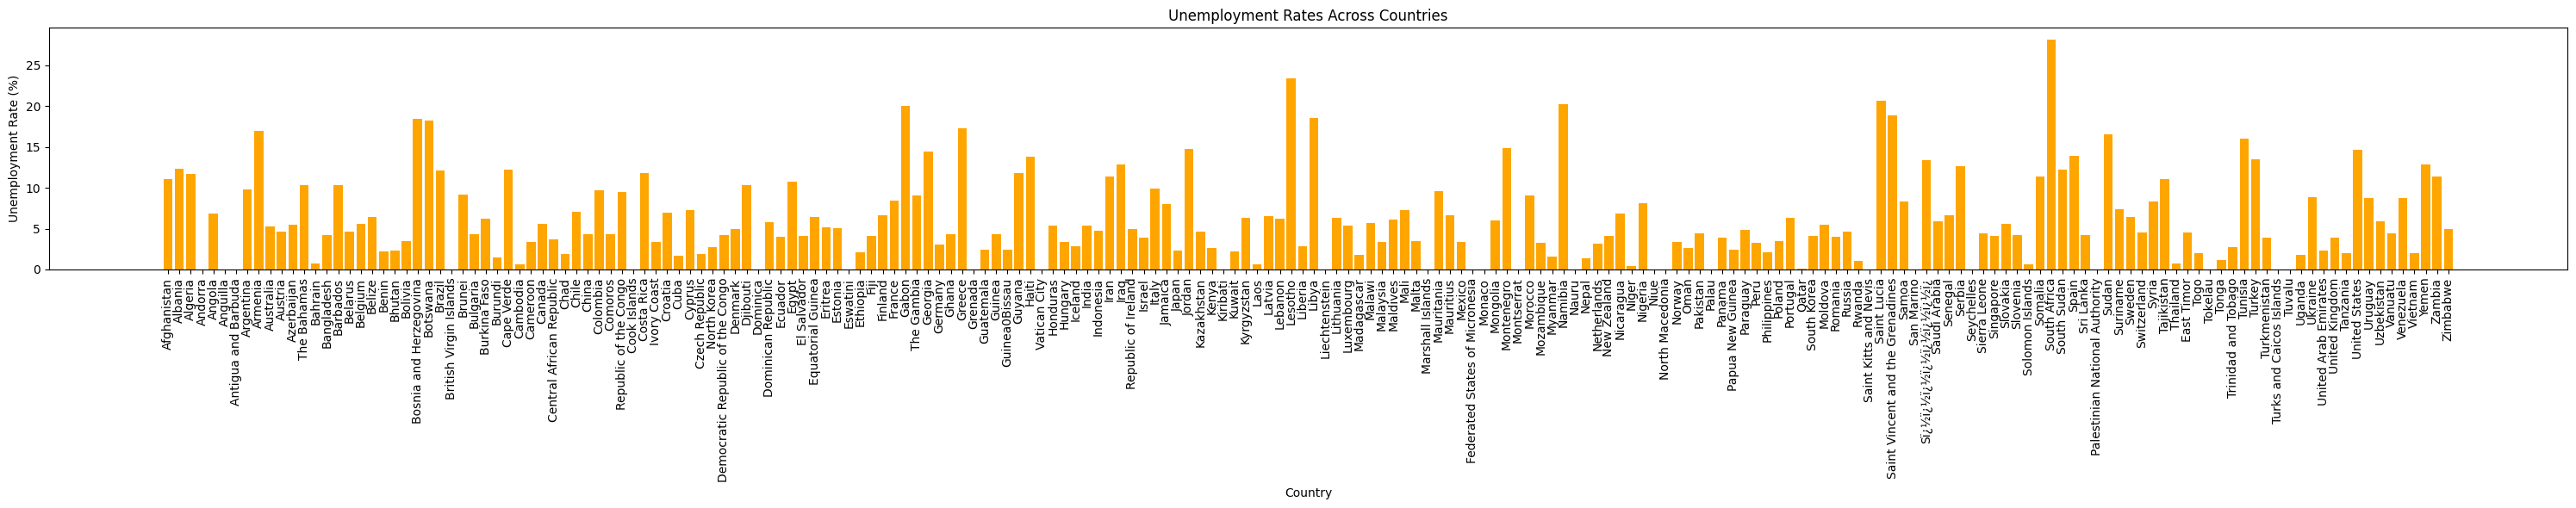

In [120]:
countries = education_report['Countries and areas']
unemployment_rates = education_report['Unemployment_Rate']

plt.figure(figsize=(30, 6))
plt.bar(countries, unemployment_rates, color='orange')
plt.xlabel('Country')
plt.ylabel('Unemployment Rate (%)')
plt.title('Unemployment Rates Across Countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 1.4 Linking Data from Different Sources

I am going to explore the correlation between educational 'success' and perceived happiness. I also want to examine gender disparity in education and its potential effect on purported happiness.

I aim to develop a predictive model to forecast happiness scores based on gender disparities in education indicators, such as enrollment rates and literacy rates between males and females.

# Stage 2

## Justification for Predicting Happiness Scores

Happiness is an important indicator of human well-being and quality of life. Gaining an understanding of the critical factors that dictate happiness, as well as the correlation between education and happiness, could offer insights into areas of society that could be highlighted and improved

# Stage 3

## 3.1a Clean the Data : Happiness Dataset

### 3.1.1a Check for Missing Values

In [121]:
print(happiness_report.isnull().sum())

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   20
Social support                       13
Healthy life expectancy at birth     54
Freedom to make life choices         33
Generosity                           73
Perceptions of corruption           116
Positive affect                      24
Negative affect                      16
dtype: int64


In [122]:
percent_columns_null = (happiness_report.isnull().sum() / len(happiness_report)) * 100

In [123]:
print("Percentage of null values in the Data")
print(percent_columns_null.apply(lambda x: "{:.2f}%".format(x)))


Percentage of null values in the Data
Country name                        0.00%
year                                0.00%
Life Ladder                         0.00%
Log GDP per capita                  0.91%
Social support                      0.59%
Healthy life expectancy at birth    2.46%
Freedom to make life choices        1.50%
Generosity                          3.32%
Perceptions of corruption           5.28%
Positive affect                     1.09%
Negative affect                     0.73%
dtype: object


The majority of columns have a number of null values, but overall the percentage is low. I decided to perform imputation using the mean value of the column, using SimpleImputer from the scikitlearn module. (scikit-learn, 2024)

In [124]:
columns_with_missing_values = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']

imputer = SimpleImputer(strategy='mean')
happiness_report[columns_with_missing_values] = imputer.fit_transform(happiness_report[columns_with_missing_values])

After performing imputation check that the report no longer contains null values.

In [125]:
happiness_report.isnull().sum()

Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64

### 3.1.2a Check for Duplicates

In [126]:
print(happiness_report.duplicated().sum())

0


### 3.1.3a Check for Inconsistencies

In [127]:
print("Number of Unique Country Names: ", happiness_report['Country name'].nunique())
print("Total Number of Country Names: ", happiness_report['Country name'].shape[0])
print("Count of Unique Country Names", happiness_report['Country name'].value_counts())

Number of Unique Country Names:  165
Total Number of Country Names:  2199
Count of Unique Country Names Country name
Lebanon       17
Indonesia     17
Kyrgyzstan    17
Kenya         17
Kazakhstan    17
              ..
Maldives       1
Guyana         1
Oman           1
Suriname       1
Cuba           1
Name: count, Length: 165, dtype: int64


## 3.1b Clean the Data : Education Dataset

### 3.1.1b Check for Missing Values

In [128]:
print(education_report.isnull().sum())

Countries and areas                        0
Latitude                                   0
Longitude                                  0
OOSR_Pre0Primary_Age_Male                  0
OOSR_Pre0Primary_Age_Female                0
OOSR_Primary_Age_Male                      0
OOSR_Primary_Age_Female                    0
OOSR_Lower_Secondary_Age_Male              0
OOSR_Lower_Secondary_Age_Female            0
OOSR_Upper_Secondary_Age_Male              0
OOSR_Upper_Secondary_Age_Female            0
Completion_Rate_Primary_Male               0
Completion_Rate_Primary_Female             0
Completion_Rate_Lower_Secondary_Male       0
Completion_Rate_Lower_Secondary_Female     0
Completion_Rate_Upper_Secondary_Male       0
Completion_Rate_Upper_Secondary_Female     0
Grade_2_3_Proficiency_Reading              0
Grade_2_3_Proficiency_Math                 0
Primary_End_Proficiency_Reading            0
Primary_End_Proficiency_Math               0
Lower_Secondary_End_Proficiency_Reading    0
Lower_Seco

### 3.1.1b Check for Duplicates

In [129]:
print(education_report.duplicated().sum())

0


### 3.1.3b Check for Inconsistencies

In [130]:
print("Number of Unique Country Names", education_report['Countries and areas'].nunique())
print("Total Number of Country Names", education_report['Countries and areas'].shape)

Number of Unique Country Names 202
Total Number of Country Names (202,)


### 3.1.4 Collate based on Country Names

hapiness has 165, education has 202. Compare and print unmatching countries

In [131]:
happiness_countries = happiness_report['Country name'].unique()
education_countries = education_report['Countries and areas'].unique()

matching_countries = set(happiness_countries).intersection(education_countries)

print("Matching Countries:")
for country in matching_countries:
    print(country)

print("Total matching countries: ", len(matching_countries))

Matching Countries:
Austria
Benin
Venezuela
Liberia
Azerbaijan
Iceland
Hungary
Namibia
Angola
Bosnia and Herzegovina
Estonia
Bahrain
Honduras
El Salvador
Mauritius
North Macedonia
Myanmar
Burkina Faso
Latvia
Kuwait
Algeria
Tanzania
South Korea
Chile
Nepal
Trinidad and Tobago
Cuba
France
Spain
Guyana
Haiti
Switzerland
Costa Rica
Chad
Eswatini
Belgium
Singapore
Mozambique
Luxembourg
Armenia
Bhutan
Morocco
Lebanon
Mauritania
Libya
Finland
Qatar
Netherlands
Albania
Bolivia
Mongolia
Philippines
Cambodia
Italy
Germany
Ethiopia
Romania
Somalia
Oman
Panama
Russia
Bangladesh
Canada
Lesotho
Moldova
Tajikistan
United Arab Emirates
Nigeria
Guatemala
Slovenia
Sri Lanka
Yemen
Peru
Uganda
Ghana
Zimbabwe
China
Jamaica
Greece
Portugal
Comoros
Denmark
Laos
India
Malaysia
Norway
Maldives
Vietnam
Sudan
Belarus
Djibouti
Serbia
Argentina
Kyrgyzstan
Dominican Republic
Slovakia
Gabon
Sierra Leone
Paraguay
Syria
Malta
Egypt
Zambia
Australia
Central African Republic
Iran
Nicaragua
New Zealand
Thailand
Georgia
T

## 3.2 Link the Datasets  : Happiness dataset and Education Dataset

* Merge on a common column (country)
* Ensure the column names match
* Remove the log/lat from education as not necessary
* Remove unmatching country rows.

In [132]:
new_happiness_report = happiness_report[happiness_report['Country name'].isin(matching_countries)]

In [133]:
new_education_report = education_report[education_report['Countries and areas'].isin(matching_countries)]

In [134]:
new_education_report['Countries and areas'].nunique()

154

In [135]:
new_education_report = new_education_report.drop(columns=['Latitude ', 'Longitude'])

In [136]:
new_education_report.rename(columns={'Countries and areas': 'Country name'}, inplace=True)
new_education_report.rename(columns={'Countries and areas': 'Country name'}, inplace=True)

Merge the two tables on the column name 'Country name' after changing the column name in the eductaion dataset.

In [137]:
merged_table = new_happiness_report.merge(new_education_report, on='Country name', how='inner')

As the education report is based off date from 2021 I decided to remove all other years.

In [138]:
merged_table = merged_table[merged_table['year'] == 2021]
merged_table.drop(columns=['year'], inplace=True)

Graph showing correlation between Happiness score (life ladder) and gross primary vs gross tertiary education using Plotly's Python graphing library. (plotly, 2024) This shows that there is a correlation between third level education and perceived happiness, more significantly affected than primary school enrollment.

In [139]:
happiness_score = merged_table['Life Ladder']
gross_primary = merged_table['Gross_Primary_Education_Enrollment']
gross_sec = merged_table['Gross_Tertiary_Education_Enrollment']
countries = merged_table['Country name']

fig = make_subplots(rows=1, cols=2, subplot_titles=('Gross_Primary_Education_Enrollment', 'Gross_Tertiary_Education_Enrollment'))

fig.add_trace(go.Scatter(x=happiness_score, y=gross_primary, mode='markers',
                         marker=dict(color='orange'),
                         text=countries,
                         name='Primary'), row=1, col=1)

fig.add_trace(go.Scatter(x=happiness_score, y=gross_sec, mode='markers',
                         marker=dict(color='green'),
                         text=countries,
                         name='Tertiary'), row=1, col=2)

fig.update_layout(title='Happiness Score vs Literacy Rate',
                  xaxis_title='Happiness Score',
                  yaxis_title='Gross Enrollment',
                  legend_title='Level')

fig.show()

# Stage 4 : Choose and train Estimator.

### 4.1 Feature Extraction

#### 4.1.1 Correlation Heatmap
As my dataset currently has more than 33 columns, I decided to generate a heatmap to observe the features with the highest correlation and then to only use these columns in training a model.

In [140]:
merged = merged_table.iloc[:, 1:]

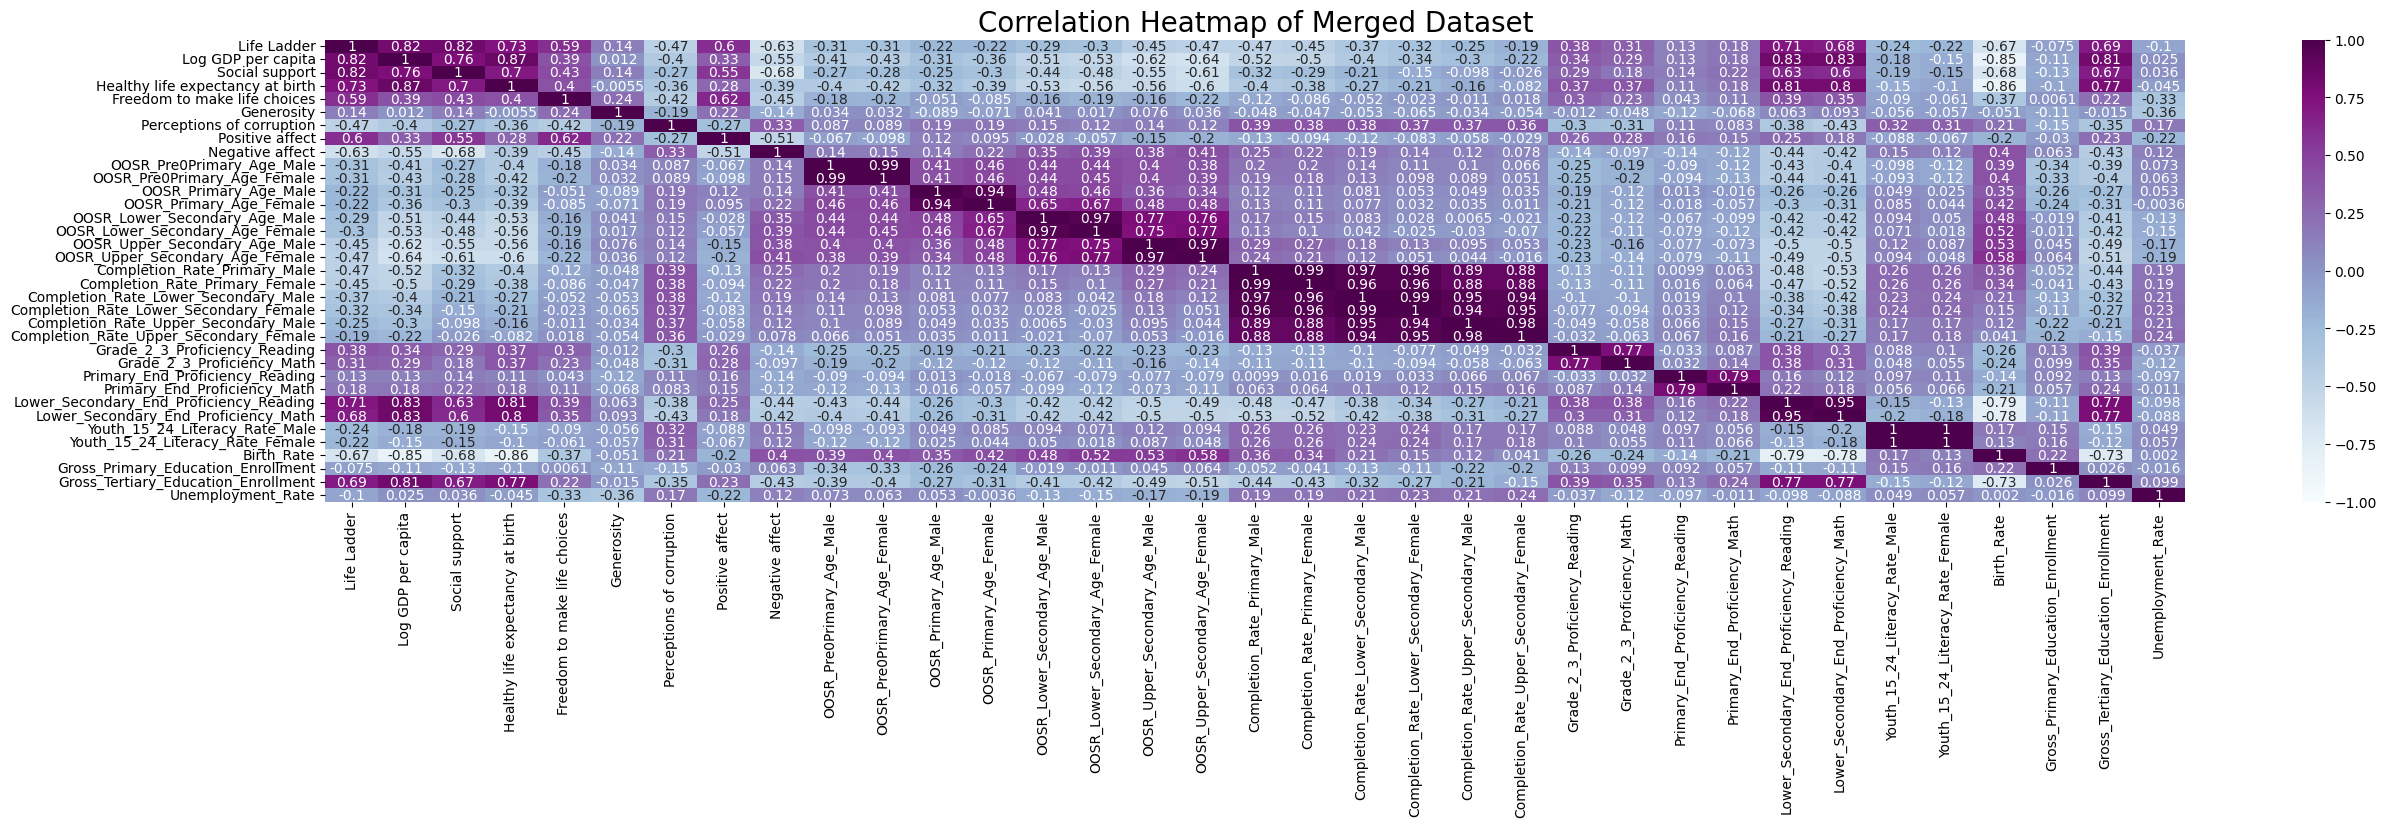

In [141]:
corr = merged.corr()
plt.figure(figsize=(30,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="BuPu",
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Correlation Heatmap of Merged Dataset", fontsize=20)
plt.show()

From the above heatmap we can see there is high correlation between life ladder and the following: Log GPD per capita, Social support, Healthy life expectancy at birth, Lower_Secondary_End_Proficiency_Reading, Gross_Tertiary_Education_Enrollment, and Lower_Secondary_End_Proficiency_Math

In [142]:
selected_features = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Lower_Secondary_End_Proficiency_Reading', 'Gross_Tertiary_Education_Enrollment', 'Lower_Secondary_End_Proficiency_Math']

#### 4.1.2 SelectKBest
 I also explored feature selection using scikit-learn module, as demonstrated in the tutorial 'How to Build a Predictive Model in Python?' (365 Data Science, 2022). It was necessary to remove the Generosity column as it contained negative values.

In [143]:
selected_features_table = merged_table.drop(columns=['Generosity'])

In [144]:
# method adapted from tutorial referenced in 4.1.2

X= selected_features_table.iloc[:,2:]
Y= selected_features_table.iloc[:,1]

best_features= SelectKBest(score_func=r_regression, k= 6)
fit= best_features.fit(X,Y)

df_scores= pd.DataFrame(fit.scores_)
df_columns= pd.DataFrame(X.columns)

features_scores= pd.concat([df_columns, df_scores], axis=1)
features_scores.columns= ['Features', 'Score']
features_scores.sort_values(by = 'Score')

,Features,Score
29,Birth_Rate,-0.667044
6,Negative affect,-0.625404
14,OOSR_Upper_Secondary_Age_Female,-0.473554
4,Perceptions of corruption,-0.470306
15,Completion_Rate_Primary_Male,-0.468765
16,Completion_Rate_Primary_Female,-0.454433
13,OOSR_Upper_Secondary_Age_Male,-0.448428
17,Completion_Rate_Lower_Secondary_Male,-0.368934
18,Completion_Rate_Lower_Secondary_Female,-0.323096
8,OOSR_Pre0Primary_Age_Female,-0.314969


The above shows the top six features match the six features highlighted earlier as being the most correlated to the life ladder variable.

In [145]:
X_features = merged_table[selected_features]

### 4.2 Split the Dataset
Split the updated dataset into training and testing sets

In [146]:
features = merged_table.columns[1:]
target = merged_table.columns[1]
y = merged_table[target].values

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

### 4.3 Choose Estimator
The next step was to choose and implemente the model(s). I implemented and evaluated both Lasso and ElasticNet Linear Regression Models, along with the Stochastic Gradient Descent Model (SGD), to determine which would be the better fit for the data. Following scikit-learn's machine learning map tutorial (scikit-learn, 2024), I selected ElasticNet due to its potential relevance for the project. However, I also explored the Lasso model, given its similarity to ElasticNet, as well as the SGD model, to compare their performances.

#### 4.3.1 Create and train the ElasticNet Model

In [147]:
elastic_model = ElasticNet()
elastic_model.fit(X_train, y_train)

ElasticNet()

#### 4.3.2 Create and train the Lasso Model
The lasso model also automatically selects relevant features improving generalisation. (Saturn Cloud, 2023)

In [148]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

Lasso()

### 4.3.3 Create and Train the SGD Model

The Stochastic Gradient Descent Model (SGD)

In [149]:
sgd_model = SGDRegressor()
sgd_model.fit(X_train, y_train)

SGDRegressor()

#### 4.3.4 Generate Predictions for all Models

In [150]:
elastic_predictions = elastic_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)
sgd_predictions = sgd_model.predict(X_test)

# Stage 5 : Model Evaluation

## 5.1 Evaluate by Calculating Mean Squared Error(MSE)
Calculate MSE to measure the distance between the actual and predicted values for both the Elastic model and the Lasso model. (Daniel, S., (2022))

In [151]:
elastic_mse = mean_squared_error(y_test, elastic_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
sgd_mse = mean_squared_error(y_test, sgd_predictions)

In [152]:
print("Elastic MSE:", elastic_mse)
print("Lasso MSE:", lasso_mse)
print("SGD MSE:", sgd_mse)

Elastic MSE: 0.7769267025542941
Lasso MSE: 0.7746715241121
SGD MSE: 2.582873285900442e+25


The result shows a more accurate result for the Lasso model, then the Elastic model. The SGD model performed the worst with the default parameters.

## 5.2 Evaluate by Calculating the R squared

Calculating the R squared measures the 'goodness of fit' of a regression model by comparing how the model fits the data comapred to a mean line ranging from 0 to 1, where the higher the value the better the fit. (Daniel, S., (2022))

In [153]:
elastic_r2 = r2_score(y_test, elastic_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)
sgd_r2 = r2_score(y_test, sgd_predictions)

In [154]:
print("Elastic R2:", elastic_r2)
print("Lasso R2:", lasso_r2)
print("SGD R2:", sgd_r2)

Elastic R2: 0.4917814589250945
Lasso R2: 0.49325666050329664
SGD R2: -1.6895597600469094e+25


The result again shows a much better result for the Lasso and Elastic model, while the SGD model performs very poorly.

## 5.3 Optimising and Test

### 5.3.1 Optimising the Lasso Model

Created a loop to traverse the number of alpha values to be checked, each time checking the mse and r2, eventually outputting the best possible model and alpha parameter, based off mse and r2 scores.

#### 5.3.1.1 Feature Scaling 

Before fine tuning, I normalised the data using StandardScalar and RobustScalar to determine which would improve the results. Normalisation helps standardise the features, ideally resulting in better overall model performance.  (atoti, n.d.)

##### 5.3.1.1.1 Robust Scaler

In [156]:
scaler = RobustScaler()
X_train_robust_scaled = scaler.fit_transform(X_train)
X_test_robust_scaled = scaler.transform(X_test)

##### 5.3.1.1.2 Standard Scaler

In [157]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [158]:
alpha_values = np.linspace(0.0001, 1, 100)

best_alpha = None
best_lasso_model = None
best_mse = float("inf")

for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_robust_scaled, y_train)
    lasso_predictions = lasso_model.predict(X_test_robust_scaled)
    lasso_mse = mean_squared_error(y_test, lasso_predictions)
    
    if lasso_mse < best_mse:
        best_alpha = alpha
        best_lasso_model = lasso_model
        best_mse = lasso_mse

lasso_predictions = best_lasso_model.predict(X_test_robust_scaled)
lasso_r2 = r2_score(y_test, lasso_predictions)

print("Best Lasso Model:")
print("Alpha:", best_alpha)
print("MSE:", best_mse)
print("R2:", lasso_r2)


Best Lasso Model:
Alpha: 0.0203
MSE: 0.37841943260160277
R2: 0.7524608546483313


Scaling the data beforehand gave a slight improvement of both MSE and r2 score using the StandardScalar, but the RobustScaler gave a better result.
RobustScaler is normally used in cases of data with outliers. Interestingly, it provided a better outcome in the case of the Lasso model. scikit-learn (n.d.) 


Results Before Normalisation
* Alpha: 0.010199999999999999
* MSE: 0.3856511937788607
* R2: 0.7477302731110707

Standard Scaler Results
* Alpha: 0.0203
* MSE: 0.38404698653221486
* R2: 0.74877964863619

RobustScaler Results
* Alpha: 0.0203
* MSE: 0.37841943260160277
* R2: 0.7524608546483313


### 5.3.2 Optimising the ElasticNet Model

The following works the same as for the Lasso model except that the inner loop additionally iterates over different values of the 'L1 ratio' parameter, 0.1 - 1. (scikit-learn, n.d.)

#### 5.3.2.1 Feature Scaling

I used the same results from feature scaling earlier for the ElasticNet Model

In [159]:
alpha_values = np.linspace(0.01, 1, 100)
l1_ratio_values = np.linspace(0.1, 1, 100)
max_iter = 10000

best_alpha = None
best_l1_ratio = None
best_elastic_model = None
best_mse = float("inf")

for alpha in alpha_values:
    for l1_ratio in l1_ratio_values:
        elastic_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
        elastic_model.fit(X_train_scaled, y_train)
        elastic_predictions = elastic_model.predict(X_test_scaled)
        elastic_mse = mean_squared_error(y_test, elastic_predictions)

        if elastic_mse < best_mse:
            best_alpha = alpha
            best_l1_ratio = l1_ratio
            best_elastic_model = elastic_model
            best_mse = elastic_mse

best_elastic_model.fit(X_train_scaled, y_train)

elastic_predictions = best_elastic_model.predict(X_test_scaled)
elastic_mse = mean_squared_error(y_test, elastic_predictions)
elastic_r2 = r2_score(y_test, elastic_predictions)

print("Best Elastic Model")
print("Alpha: ", best_alpha)
print("L1 Ratio: ", best_l1_ratio)
print("MSE: ", elastic_mse)
print("R2: ", elastic_r2)


Best Elastic Model
Alpha:  0.05
L1 Ratio:  0.2090909090909091
MSE:  0.3812342864628619
R2:  0.7506195472019468


In the case of the ElasticNet Model, scaling the features using StandardScaler not only improved the MSE and R2 results, it also reduced convergance time significantly.

Interestingly, in the case of the ElasticNet model, it also performed better using the RobustScaler. This may be due to a difference in sensitivity to scaling by the model. Ouput as follows:

RobustScaler Results (approx 10.8s)
* Alpha:  0.02
* L1 Ratio:  0.33636363636363636
* MSE:  0.37696575350260825
* R2:  0.7534117637475465

StandardScaler Results (approx 11.1s)
* Alpha:  0.05
* L1 Ratio:  0.2090909090909091
* MSE:  0.3812342864628619
* R2:  0.7506195472019468

No Scaler Results (approx 27.3s)
* Alpha:  0.01
* L1 Ratio:  0.9363636363636363
* MSE:  0.38519590698139816
* R2:  0.7480280942455694

### 5.3.3 Optimising the SGD Model

In [163]:
alpha_values = np.linspace(0.0001, 1, 100)
l1_ratio_values = np.linspace(0.01, 1, 100)
max_iter = 1000

best_alpha = None
best_sgd_model = None
best_l1_ratio = None
best_mse = float("inf")

random_state = 42
for alpha in alpha_values:
    for l1_ratio in l1_ratio_values:
        sgd_model = SGDRegressor(alpha=alpha, max_iter=max_iter, l1_ratio=l1_ratio, random_state=random_state)
        sgd_model.fit(X_train_robust_scaled, y_train)
        sgd_predictions = sgd_model.predict(X_test_robust_scaled)
        sgd_mse = mean_squared_error(y_test, sgd_predictions)
        
        if sgd_mse < best_mse:
            best_alpha = alpha
            best_sgd_model = sgd_model
            best_l1_ratio = l1_ratio
            best_mse = sgd_mse

sgd_predictions = best_sgd_model.predict(X_test_robust_scaled)
sgd_r2 = r2_score(y_test, sgd_predictions)

print("Best SGD Model:")
print("Alpha:", best_alpha)
print("L1 ratio: ", best_l1_ratio)
print("MSE:", best_mse)
print("R2:", sgd_r2)


Best SGD Model:
Alpha: 0.0203
L1 ratio:  0.01
MSE: 0.38770354856706724
R2: 0.7463877465216238


Scaling the SGD model features vastly improved the scores. The SGD model is very sensitive to feature scaling and performs much better on normalised data, so this result is not surprising. In the case of the SGD model, the RobustScaler performed slightly better, as can be seen below.

RobustScaler Results
* Alpha: 0.0203
* L1 ratio:  0.01
* MSE: 0.38770354856706724
* R2: 0.7463877465216238

StandardScalar Results
* Alpha: 0.13
* MSE: 0.39239607587197767
* R2: 0.7433181784748374

No Scaling Results
* Best SGD Model:
* Alpha: 1.0
* MSE: 6.542468966072278e+23
* R2: -4.279688189418018e+23

### 5.3.4 Scatter Plot of Actual vs Predicted Values of All Models

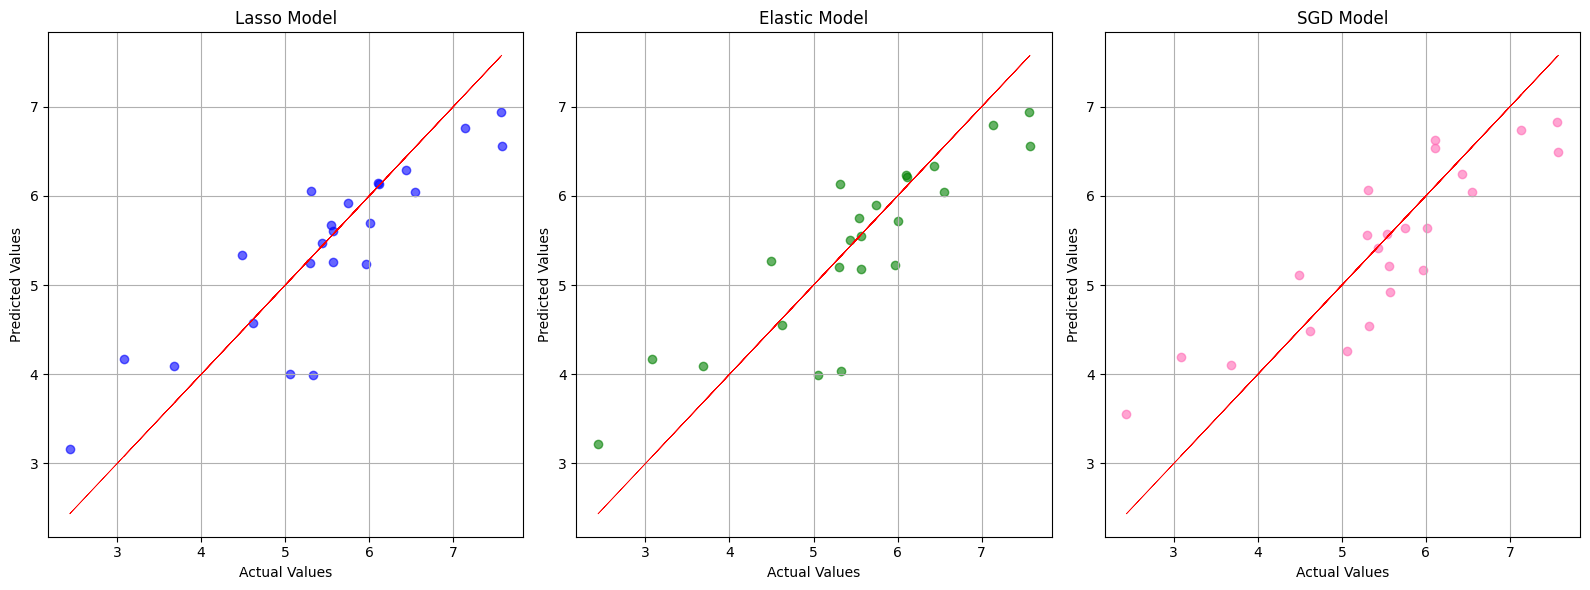

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].scatter(y_test, lasso_predictions, color='blue', alpha=0.6)
axes[0].plot(y_test, y_test, color='red', linewidth=0.5)
axes[0].set_title('Lasso Model')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].grid(True)

axes[1].scatter(y_test, elastic_predictions, color='green', alpha=0.6)
axes[1].plot(y_test, y_test, color='red', linewidth=0.5)
axes[1].set_title('Elastic Model')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].grid(True)

axes[2].scatter(y_test, sgd_predictions, color='hotpink', alpha=0.6)
axes[2].plot(y_test, y_test, color='red', linewidth=0.5)
axes[2].set_title('SGD Model')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Stage 6 : Results and Conclusions

In conclusion, all the models yielded almost identical results after optimisation, with the best Lasso model having an alpha value of 0.0203 and achieving an MSE of 0.3784 and an R2 of 0.7525. The best ElasticNet model had an alpha of 0.05 and an L1 ratio of 0.2121, resulting in an MSE of 0.3813 and an R2 of 0.7506. Similarly, the SGD model with an alpha of 0.0203 and an L1 ratio of 0.01 achieved an MSE of 0.3877 and an R2 of 0.7464. During the optimisation stage, testing a range of values from 0.0001 to 1 for the SGD and Lasso models, and 0.01 to 1 for the ElasticNet model, found that the optimal alpha values were 0.0203 for both, leading to a slight improvement in predictions.
Additionally, the best alpha ratio for the ElasticNet model was found to be 0.5. The MSE results for both models after optimisation showed a significant improvement compared to the initial values of 0.77, with the refined models achieving approximately 0.39. This suggests that the predicted life ladder values are much closer to the actual values, as a lower MSE indicates better model performance. Furthermore, the R-squared (R2) values indicated that all models can predict approximately 75% of the variance in the target variable. This represents a notable improvement from the pre-fine-tuning R2 values of 0.49 for both the Lasso and Elastic, and -4.279688189418018e+23 for the SGD. The biggest improvement through feature scaling and fine tuning was for the SGD model, leading to near identcal results as the other two models.
Despite the relatively close approximation, there remains a discernible gap between the predicted and actual values. Further investigation into the factors contributing to this variance is necessary to enhance the accuracy of the models and improve their predictive capabilities.

# References


* scikit-learn. (2024). Choosing the right estimator [Online] Available at: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html [Accessed 11 April 2024].

* Sarah El Shatby. (2022). Predictive Model in Python. [Online] Available at: https://365datascience.com/tutorials/python-tutorials/predictive-model-python/ [Accessed 11 April 2024].

* Saturn Cloud. (2023). Python Classification with Lasso: How to Predict Classes. [Online] Available at: https://saturncloud.io/blog/python-classification-with-lasso-how-to-predict-classes/#:~:text=Feature%20Selection%3A%20Lasso%20automatically%20selects,feature%2Dto%2Dsample%20ratio. [Accessed 11 April 2024].

* scikit-learn developers. (2024). Imputation of missing values. [Online] Available at: https://scikit-learn.org/stable/modules/impute.html [Accessed 11 April 2024]

* plotly (2024). Scatter Plots in Python [Online] Available at: https://plotly.com/python/line-and-scatter/ [Accessed 13 April 2024].

* scikit-learn (n.d.) 'Preprocessing data', scikit-learn Documentation, [Online]. Available at: https://scikit-learn.org/stable/modules/preprocessing.html (Accessed: 13 April 2024).

* IBM Developer. (2024). Lasso regression: Automatic feature selection. [Online] Available at: https://developer.ibm.com/tutorials/awb-lasso-regression-automatic-feature-selection/ [Accessed 12 April 2024].

* Stephy Daniel. (2022). Model Evaluation for Classification and Regression Analysis. [Online] Available at: https://medium.com/@stephy.SD99/model-evaluation-for-classification-and-regression-analysis-6fa2d11a4a09 [Accessed 12 April 2024].

* LinkedIn. (n.d.) 'How Do You Interpret Coefficients - Elastic?', LinkedIn. Available at: https://www.linkedin.com/advice/0/how-do-you-interpret-coefficients-elastic#:~:text=The%20parameters%20of%20elastic%20net%20regression%20are%20alpha%20and%20lambda,the%20performance%20of%20the%20model. (Accessed: 17 April 2024).

* Hackernoon. (2018) 'An Introduction to Ridge, Lasso, and Elastic Net Regression,' Hacker Noon. Available at: https://hackernoon.com/an-introduction-to-ridge-lasso-and-elastic-net-regression-cca60b4b934f (Accessed: 17 April 2024).

* Brownlee, J. (2023) 'k-Fold Cross-Validation', Machine Learning Mastery, [Online]. Available at: https://machinelearningmastery.com/k-fold-cross-validation/ (Accessed: 17 April 2024).

* scikit-learn (n.d.) 'ElasticNet', scikit-learn Documentation, [Online]. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html (Accessed 11 April 2024).

* atoti (n.d.) 'When to Perform a Feature Scaling', atoti Articles, [Online]. Available at: https://www.atoti.io/articles/when-to-perform-a-feature-scaling/#:~:text=In%20regression%2C%20it%20is%20often,are%20set%20to%20their%20means (Accessed 11 April 2024).

* ai-jobs.net (2023) 'ElasticNet Explained', AI Jobs, [Online]. Available at: https://ai-jobs.net/insights/elasticnet-explained/#:~:text=Data%20Scaling%3A%20It%20is%20essential,from%20dominating%20the%20regularization%20process (Accessed: 21 April 2024).